# TEXTUAL DATA ANALYSIS EXERCISE 4

## Preface

Duplicate detection is one of the applications of embeddings. Let's try!

Grab the first 2000 examples of this dataset: https://huggingface.co/datasets/sentence-transformers/quora-duplicates (the "pairs" version) which contains examples of duplicate questions in Quora. Each example has an *anchor* and a *positive* and they form a duplicate question pair.

Embed both anchors and positives with some embedding model. You can get away with a small, simple model like `all-MiniLM-L6-v2` which allows you to run this on CPU. Index the *positive* embeddings in FAISS (`IndexFlatL2` is quite enough!). Then, query the index with the *anchors* and evaluate how often the correct hit (i.e. the corresponding *positive* to the query *anchor*) is in top 1 and how often it is in top 5 (say). In other words, you are evaluating the accuracy of the retrieval.

## SETUP

### install

In [18]:
!pip3 install -q datasets faiss-cpu

In [19]:
from sentence_transformers import SentenceTransformer
import faiss
from datasets import load_dataset

## LOAD

### load dataset

In [20]:
quora_string = 'sentence-transformers/quora-duplicates'
dataset = load_dataset(quora_string, 'pair')
dataset

DatasetDict({
    train: Dataset({
        features: ['anchor', 'positive'],
        num_rows: 149263
    })
})

In [21]:
# select first 2000
dataset = dataset['train'].select(range(2000))
dataset

Dataset({
    features: ['anchor', 'positive'],
    num_rows: 2000
})

## Model

In [22]:
model = SentenceTransformer('intfloat/e5-small-v2')

## Embed

In [23]:
anchors = model.encode(dataset['anchor'])

In [24]:
print(anchors.__class__)
print(anchors.shape)

<class 'numpy.ndarray'>
(2000, 384)


In [25]:
positives = model.encode(dataset['positive'])

In [26]:
print(positives.__class__)
print(positives.shape)

<class 'numpy.ndarray'>
(2000, 384)


## Test with template examples ''exhaustive lookup'' -- to get the feel of the mechanics

(not the actual task)

In [27]:
dataset['anchor'][0]

'Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?'

In [28]:
query=dataset['anchor'][0]

q_emb=model.encode([query]) #we could do without the [...] but this way it is easy to extend to many queries at once
print(type(q_emb))
q_emb.shape

<class 'numpy.ndarray'>


(1, 384)

In [29]:
from sklearn.metrics.pairwise import cosine_similarity as cs
similarities=cs(q_emb,positives)
print(similarities.shape)

(1, 2000)


In [30]:
best_match_idxs=similarities.argmax(axis=1)
print(best_match_idxs)
best_match = dataset['positive'][0]

[0]


In [31]:
print()
print(f'{query}', end="\n\n")
print("has best match in positives as", end ="\n\n")
print(f'{best_match}')


Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?

has best match in positives as

I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?


## Faiss

(the actual task)

 Index the *positive* embeddings in FAISS (`IndexFlatL2` is quite enough!). Then, query the index with the *anchors* and evaluate how often the correct hit (i.e. the corresponding *positive* to the query *anchor*) is in top 1 and how often it is in top 5 (say). In other words, you are evaluating the accuracy of the retrieval.

In [32]:
dims = positives.shape[1] # gives the dimensinality counts

In [59]:
coarse_quantizer = faiss.IndexFlatL2(dims)
nlist = 50 # for better true acc higher
n_partitions = 8
assert dims%n_partitions==0, f"n_partitions {n_partitions} must divide dims {dims}"
nbits = 8
index = faiss.IndexIVFPQ(coarse_quantizer, dims, nlist, n_partitions, nbits)
index.nprobe = 5 # Count of voronoi cells to probe
index.train(positives[:500])
index.add(positives)

In [60]:
# inspiration from this

distances, indices = index.search(q_emb,5)

print(f'the actual querystring with index 0 is:\n{query}', end="\n\n")
for i, indx in enumerate(indices[0]):
  text = dataset['positive'][i]
  if indx == 0:
    print("matched rank")
  print(f'ranked as {i+1} from index {indx}')
  print(f'with text: {text}')

the actual querystring with index 0 is:
Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?

matched rank
ranked as 1 from index 0
with text: I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?
ranked as 2 from index 432
with text: What should I do to be a great geologist?
ranked as 3 from index 1949
with text: How can I see all my Youtube comments?
ranked as 4 from index 681
with text: How can you make physics easy to learn?
ranked as 5 from index 1445
with text: What was your first sexual experience?


In [61]:
# the actual task

top1 = 0
top5 = 0

# for plot
accuracy = []
divisor = 1

for i, a in enumerate(anchors):
  emb_arr = anchors[i:i+1]
  distances, indices = index.search(emb_arr, 5) # search for top 5 hits
  if i == indices[0][0]:
    top1 += 1
  elif i in indices[0]:
    top5 += 1
  accuracy.append((top1 + top5) / divisor)
  divisor += 1



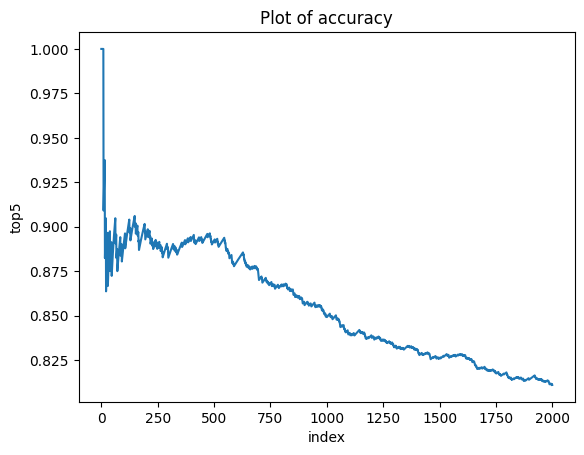

In [62]:
import matplotlib.pyplot as plt

plt.plot(accuracy)
plt.title('Plot of accuracy')
plt.xlabel('index')
plt.ylabel('top5')
plt.show()

In [63]:
print(f"final accuracy of the model is {accuracy[-1]}")

final accuracy of the model is 0.811
